In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
%matplotlib inline

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [3]:
import io
import datetime
import urllib.request

# Seasonal Decomposition

## Trial Data

We use the well known [Mauna Loa Carbon Dioxide dataset][1]. Following function fetch the file from ftp:

[1]: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt

In [4]:
def to_dataframe(fname=None):
    """
    Read Moana Loa CO2 FWF Source File:
    """
    if fname is None:
        uri = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt'
        with urllib.request.urlopen(uri) as response:
            lines = response.read().decode().split("\n")
        with open("CO2_{:%Y%m%d}.txt".format(datetime.datetime.utcnow()), 'w') as file:
            file.write("\n".join(lines))
    else:
        with open(fname) as file:
            lines = map(str.strip, file.readlines())
    stream = io.StringIO("\n".join(filter(lambda x: not(x.startswith('#')), lines)))
    df = pd.read_fwf(
        stream,
        header=None, usecols=[0, 1, 2, 4, 5],
        names=['year', 'month', 'day', 'value', 'ndays'],
        parse_dates={'timestamp': ['year', 'month', 'day']},
        index_col='timestamp',
        na_values=[-999.99]
    )
    return df

In [5]:
df = to_dataframe('co2_weekly_mlo.txt').interpolate(mode='time')
df.head()

,value,ndays
timestamp,,
1974-05-19,333.34,6
1974-05-26,332.95,6
1974-06-02,332.32,5
1974-06-09,332.18,7
1974-06-16,332.37,7


Plotting data shows up the CO2 trend:

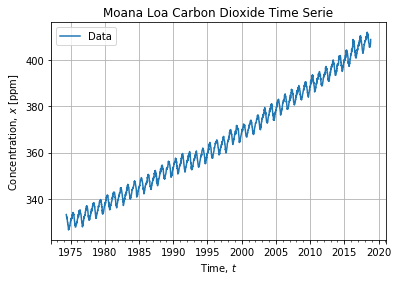

In [6]:
axe = df['value'].plot(label='Data')
axe.set_title('Moana Loa Carbon Dioxide Time Serie')
axe.set_xlabel('Time, $t$')
axe.set_ylabel('Concentration, $x$ $[\mathrm{ppm}]$')
axe.grid()
axe.legend()

## ARIMA

 - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
 - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.fit.html#statsmodels.tsa.arima_model.ARIMA.fit
 - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.html#statsmodels.tsa.arima_model.ARIMAResults
 https://stackoverflow.com/questions/31690134/python-statsmodels-help-using-arima-model-for-time-series/54250123#54250123

In [7]:
x = df.loc[:,"value"].resample('MS').agg(['mean', 'std', 'count'])
x.head()

,mean,std,count
timestamp,,,
1974-05-01,333.1450,0.275772,2
1974-06-01,332.0280,0.366838,5
1974-07-01,330.7125,0.678988,4
1974-08-01,329.0725,0.620880,4
1974-09-01,327.3240,0.517958,5


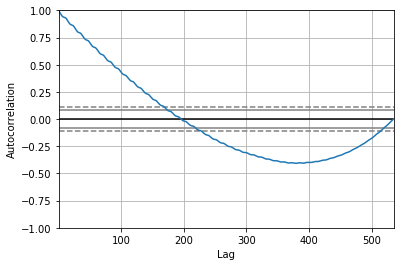

In [8]:
autocorrelation_plot(x['mean'])

In [9]:
model = ARIMA(x['mean'], order=(12, 1, 0))
fit = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

In [10]:
fit.aic

498.9123301749703

In [11]:
fit.params

const            0.148655
ar.L1.D.mean    -0.092102
ar.L2.D.mean    -0.095437
ar.L3.D.mean    -0.240162
ar.L4.D.mean    -0.247357
ar.L5.D.mean    -0.218295
ar.L6.D.mean    -0.141171
ar.L7.D.mean    -0.169010
ar.L8.D.mean    -0.265605
ar.L9.D.mean    -0.224225
ar.L10.D.mean   -0.218797
ar.L11.D.mean    0.087297
ar.L12.D.mean    0.417101
dtype: float64

In [12]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.mean   No. Observations:                  534
Model:                ARIMA(12, 1, 0)   Log Likelihood                -235.456
Method:                       css-mle   S.D. of innovations              0.371
Date:                Thu, 24 Jan 2019   AIC                            498.912
Time:                        09:52:04   BIC                            558.838
Sample:                    06-01-1974   HQIC                           522.360
                         - 11-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1487      0.007     22.171      0.000       0.136       0.162
ar.L1.D.mean     -0.0921      0.040     -2.330      0.020      -0.170      -0.015
ar.L2.D.mean     -0.0954      0.040     -2.414      0.016      -0.173      -0.018
ar.L3.D.mean     -0.2402      0.039     -6.235      0.000      -0.316      -0.165
ar.L4.D.mean     -0.2474      0.039     -6.365      0.000      -0.324      -0.171
ar.L5.D.mean     -0.2183      0.039     -5.644      0.000      -0.294      -0.142
ar.L6.D.mean     -0.1412      0.039     -3.633      0.000      -0.217      -0.065
ar.L7.D.mean     -0.1690      0.039     -4.319      0.000      -0.246      -0.092
ar.L8.D.mean     -0.2656      0.039     -6.893      0.000      -0.341      -0.190
ar.L9.D.mean     -0.2242      0.039     -5.767      0.000      -0.300      -0.148
ar.L10.D.mean    -0.2188      0.039     -5.663      0.000      -0.295      -0.143
ar.L11.D.mean     0.0873      0.040      2.202      0.028       0.010       0.165
ar.L12.D.mean     0.4171      0.040     10.558      0.000       0.340       0.495
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1184           -0.0000j            1.1184           -0.5000
AR.2            -0.9747           -0.5039j            1.0972           -0.4241
AR.3            -0.9747           +0.5039j            1.0972            0.4241
AR.4            -0.5668           -0.9102j            1.0723           -0.3386
AR.5            -0.5668           +0.9102j            1.0723            0.3386
AR.6            -0.0370           -1.0714j            1.0720           -0.2555
AR.7            -0.0370           +1.0714j            1.0720            0.2555
AR.8             0.5002           -0.8712j            1.0046           -0.1671
AR.9             0.5002           +0.8712j            1.0046            0.1671
AR.10            0.8670           -0.5009j            1.0014           -0.0834
AR.11            0.8670           +0.5009j            1.0014            0.0834
AR.12            1.3317           -0.0000j            1.3317           -0.0000
------------------------------------------------------------------------------
"""

In [13]:
residuals = pd.DataFrame(fit.resid, columns=['residuals'])
residuals.head()

,residuals
timestamp,
1974-06-01,-1.265655
1974-07-01,-0.590555
1974-08-01,-0.898296
1974-09-01,-0.970650
1974-10-01,0.747277


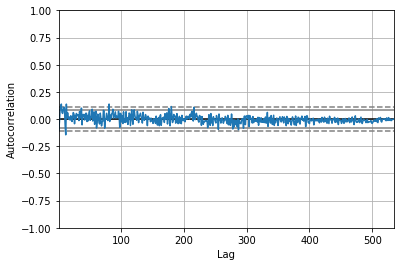

In [32]:
autocorrelation_plot(residuals)

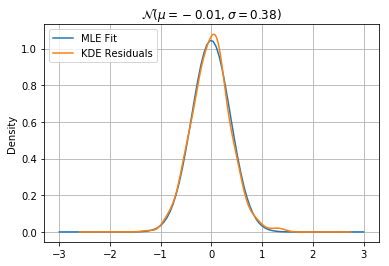

In [29]:
t = np.linspace(-3, 3, 100)
p = stats.norm.fit(residuals)
fig, axe = plt.subplots()
axe.plot(t, stats.norm(*p).pdf(t))
residuals.plot(kind='kde', ax=axe)
axe.set_title(r'$\mathcal{N}(\mu=%.2f,\sigma=%.2f)$' % p)
axe.legend(['MLE Fit', 'KDE Residuals'], loc='upper left')
axe.grid()

In [30]:
preds = fit.predict(2, len(x['mean'])+52*12, typ='levels')

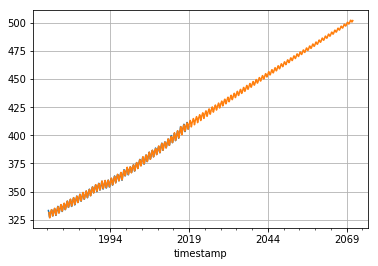

In [31]:
ax = x['mean'].plot()
preds.plot(ax=ax)
ax.grid()

In [1]:
preds = fit.predict(2, len(x['mean'])+52*12, typ='levels')

NameError: name 'fit' is not defined